In [99]:
import shap
import os
import numpy as np
import pandas as pd
import torch
import argparse
from models.data_process import get_datatensor_partitions, prepare_nonproto_features, generate_partition_datatensor
from models.dataset import ProtospacerDataset, ProtospacerExtendedDataset
from src.utils import create_directory, one_hot_encode, get_device, ReaderWriter, print_eval_results
import matplotlib.pyplot as plt
from models.data_process import construct_load_dataloaders
from models.FFN import RegressionFFNN
from models.CNN import PredictionCNN
from models.RNN import PredictionRNN
from models.Transformer import PredictionTransformer

In [100]:
cmd_opt = argparse.ArgumentParser(description='Argparser for data')
cmd_opt.add_argument('-model_name',  type=str, help = 'name of the model')
cmd_opt.add_argument('-exp_name',  type=str, help = 'name of the experiment')

cmd_opt.add_argument('-data_dir',  type=str,default = './data/', help = 'directory of the data')
cmd_opt.add_argument('-target_dir',  type=str, default='processed',  help = 'folder name to save the processed data')
cmd_opt.add_argument('-working_dir',  type=str, default='./', help = 'the main working directory')
cmd_opt.add_argument('-output_path', type=str, help='path to save the trained model')
cmd_opt.add_argument('-model_path', type=str, help='path to trained model')
cmd_opt.add_argument('-random_seed', type=int,default=42)
cmd_opt.add_argument('-epoch_num', type=int, default =200, help='number of training epochs')
args, _ = cmd_opt.parse_known_args()

In [101]:
def get_data_ready(args, normalize_opt = 'max', train_size=0.9, fdtype=torch.float32):
    ## prepare the data
    data_dir = args.data_dir + args.target_dir
    data_partitions = ReaderWriter.read_data(data_dir + '/data_partitions.pkl')
    data = ReaderWriter.read_data(data_dir + '/list_of_x_f_y.pkl')
    x_protospacer, x_extended_f,x_non_protos_f, y = data

    if args.model_name in {'CNN', 'FFN'}:
        ## onehot-encode the protospacer features
        proc_x_protospacer = one_hot_encode(x_protospacer)
        proc_x_protospacer = proc_x_protospacer.reshape(proc_x_protospacer.shape[0], -1)
    elif args.model_name in {'Transformer', 'RNN'}:
        proc_x_protospacer = x_protospacer 
        
    x_non_protos_f_df, x_non_protos_f_norm = prepare_nonproto_features(x_non_protos_f, normalize_opt)
    
    if args.exp_name == 'protospacer_extended':
        x_non_protos_features = x_non_protos_f_norm
    elif args.exp_name == 'protospacer':
        x_non_protos_features = None
    dpartitions, datatensor_partitions = get_datatensor_partitions(data_partitions,
                                                                   args.model_name,
                                                                   proc_x_protospacer,
                                                                   y,
                                                                   x_non_protos_features,
                                                                   fdtype=fdtype,
                                                                   train_size=train_size,
                                                                   random_state=args.random_seed)
    return dpartitions, datatensor_partitions

In [103]:
args.model_name = 'CNN'
args.exp_name = 'protospacer'
dsettypes = ['test']
run_num = 0


In [104]:
gpu_index = 0
res_desc = {}
version=2
model_path = os.path.join(args.working_dir, 
                                  'output', 
                                  f'{args.model_name}_v{version}',
                                  args.exp_name)


dpartitions, datatensor_partitions = get_data_ready(args, 
                                                            normalize_opt='max',
                                                            train_size=0.9, 
                                                            fdtype=torch.float32)

--- max normalization ---
we are here


In [105]:
train_val_path = os.path.join(model_path, 'train_val')
test_path = os.path.join(model_path, 'test')
to_gpu = False
gpu_indx = 0
device = get_device(to_gpu, gpu_indx)

In [106]:
data_partition = datatensor_partitions[run_num]
wrk_dir = create_directory('run_{}'.format(run_num), train_val_path)
state_dict_pth = None

if os.path.exists(wrk_dir):
    # load state_dict pth
    state_dict_pth = os.path.join(wrk_dir, 'model_statedict')
    # load mconfig
    mconfig = ReaderWriter.read_data(os.path.join(wrk_dir, 'config', 'mconfig.pkl'))
    # load exp_options
    exp_options = ReaderWriter.read_data(os.path.join(wrk_dir, 'config', 'exp_options.pkl'))


In [107]:
dsettypes = ['train', 'test']

In [108]:
test_pth =  create_directory('run_{}'.format(run_num), test_path)
dataloader_config = mconfig['dataloader_config']
cld = construct_load_dataloaders(data_partition, dsettypes, 'regression', dataloader_config, wrk_dir)
data_loaders, epoch_loss_avgbatch, score_dict,  flog_out = cld
fdtype = exp_options['fdtype']
num_epochs = 1
print('number of epochs', num_epochs)

model_config = mconfig['model_config']
mlpembedder_config = mconfig.get('mlpembedder_config', None)
input_size = exp_options.get('input_size')
# legacy support
if input_size is None:
    if mlpembedder_config is not None:
        input_size = 20 + mlpembedder_config.input_dim
    else:
        input_size = 20
        
model_name = exp_options.get('model_name')
print('model_name:', model_name)
print('input_size:', input_size)


test
number of epochs 1
model_name: CNN
input_size: 20


In [109]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f831519efd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8315194070>}

In [110]:
if model_name == 'Transformer':
    model = PredictionTransformer(input_size=input_size,
                                    embed_size=model_config.embed_dim, 
                                    num_nucleotides=4, 
                                    seq_length=20, 
                                    num_attn_heads=model_config.num_attn_heads, 
                                    mlp_embed_factor=model_config.mlp_embed_factor, 
                                    nonlin_func=model_config.nonlin_func, 
                                    pdropout=model_config.p_dropout, 
                                    num_transformer_units=model_config.num_transformer_units,
                                    pos_embed_concat_opt=model_config.pos_embed_concat_opt,
                                    pooling_mode=model_config.pooling_opt,
                                    multihead_type=model_config.multihead_type,
                                    mlp_embedder_config=mlpembedder_config,
                                    num_classes=1)
elif model_name == 'CNN':
    model = PredictionCNN(k=model_config.k, mlp_embedder_config=mlpembedder_config)

elif model_name == 'FFN':
    model = RegressionFFNN(80, model_config.h, mlp_embedder_config=mlpembedder_config)

elif model_name == 'RNN':
    model = PredictionRNN(input_dim=input_size,
                            embed_dim=model_config.embed_dim,
                            hidden_dim=model_config.hidden_dim, 
                            z_dim=model_config.z_dim,
                            outp_dim=1,
                            seq_len=20,
                            device=device,
                            num_hiddenlayers=model_config.num_hidden_layers, 
                            bidirection= model_config.bidirection, 
                            rnn_pdropout=model_config.p_dropout, 
                            rnn_class=model_config.rnn_class, 
                            nonlinear_func=model_config.nonlin_func,
                            pooling_mode=model_config.pooling_mode,
                            mlp_embedder_config=mlpembedder_config,
                            fdtype = fdtype)
    


In [111]:
if(state_dict_pth):  # load state dictionary of saved models
    model.load_state_dict(torch.load(os.path.join(state_dict_pth, f'{model_name}.pkl'), map_location=device))


In [112]:
test_dataloader = data_loaders['test']
train_dataloader = data_loaders['train']
device = 'cpu'
with torch.no_grad():
    for batch_idx, sbatch in enumerate(test_dataloader):

        if len(sbatch) == 2:
            x, y = sbatch
            x = x.to(device)
            x_f = None
            y = y.to(device)
        elif len(sbatch) == 3:
            x, x_f, y = sbatch
            x = x.to(device)
            x_f = x_f.to(device)
            y = y.to(device)

        #out = model(x, x_f)

In [113]:
train_x, train_y = next(iter(train_dataloader))

In [114]:
test_x, test_y = next(iter(test_dataloader))

In [115]:
feature_list =[]
for i in range(20):
    
    feature_list.append("position_"+str(i+1))


In [116]:
feature_list =[]
Dictionary = ['A', 'C', 'T', 'G']
for i in range(20):
    for j in Dictionary:
        feature_list.append("position_"+str(i+1)+"_"+j)

extend_feature_list = ['polytvalues', 'polygvalues', 'polyavalues', 'polycvalues',
       'Proto_GC_content', 'Proto_GC_count', 'spacermt', 'MFE_scaffold_spacer_HDV', 'MFE_spacer_HDV',
       'MFE_scaffold_spacer']
#feature_list = feature_list + extend_feature_list

len(feature_list)

80

In [117]:
explainer =shap.DeepExplainer(model,train_x)
x = test_x.clone().detach()
shap_values = explainer.shap_values(x[:40,:])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


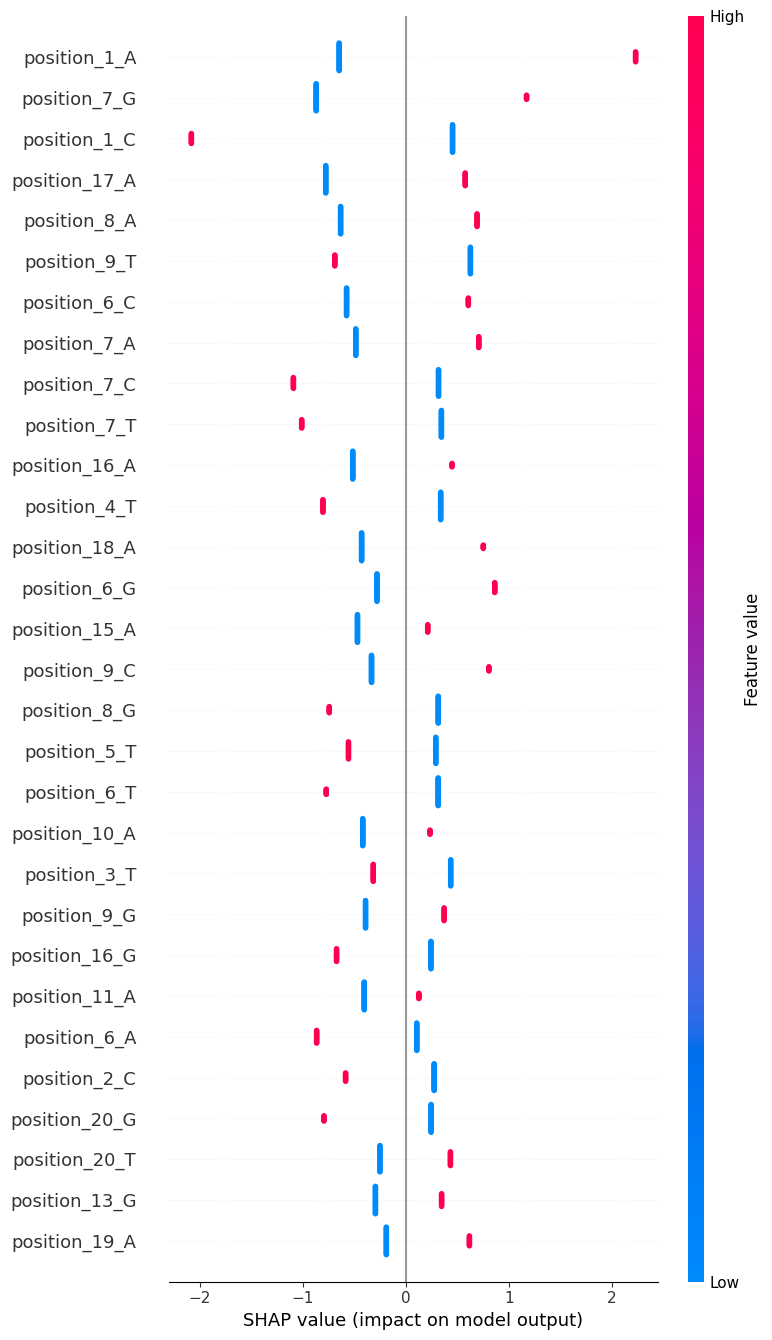

In [118]:
plot= shap.summary_plot(shap_values,x[:40,:],feature_names=feature_list, max_display=30)


In [119]:
input_tensor = test_x.clone().detach()

In [120]:
def get_difference(inputs, reference):
    model.eval()
    inputs.requires_grad = True
    output = model(inputs)
    output_ref = model(reference)
    difference = output - output_ref
    return difference

In [121]:
# Define the function that computes the integrated gradients
def integrated_gradients(inputs, reference, steps):
    delta = (inputs - reference) / steps
    reference = reference.clone().detach()
    reference.requires_grad = True
    output = get_difference(inputs, reference)
    for i in range(steps):
        reference.data += delta
        output += get_difference(inputs, reference)
    output /= steps
    integrated_gradients = delta * output
    return integrated_gradients

In [122]:
reference_tensor = torch.zeros_like(input_tensor[:100,:])

In [123]:
steps = 100
ig = integrated_gradients(input_tensor[:100,:], reference_tensor, steps)


In [124]:
feature_importance = torch.mean(torch.abs(ig), axis=0).detach().numpy()

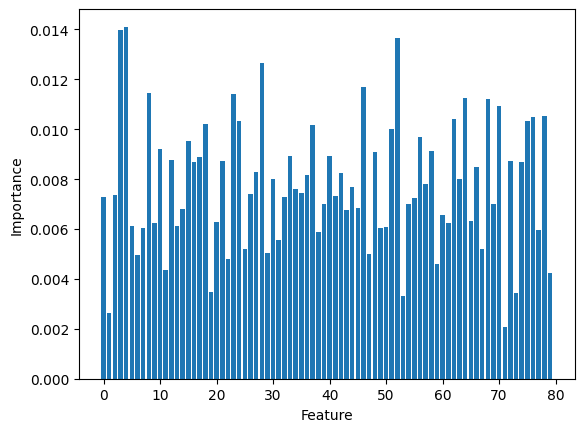

In [125]:
plt.bar(range(feature_importance.shape[0]), feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [126]:
feature_importance[sorted_indices]

array([0.01410823, 0.01398063, 0.01123034, 0.0136519 , 0.01125432,
       0.01144163, 0.01170628, 0.01049361, 0.01264784, 0.01141395,
       0.01033706, 0.01093596, 0.00889705, 0.01018369, 0.01034883,
       0.01053935, 0.00910677, 0.00969193, 0.00876602, 0.01039354,
       0.01019527, 0.00999235, 0.00892667, 0.00922648, 0.00800839,
       0.00801171, 0.00873304, 0.00702222, 0.00745538, 0.00829681,
       0.00847954, 0.00871302, 0.0091314 , 0.00867502, 0.00870223,
       0.00734521, 0.00892043, 0.00727054, 0.00675162, 0.00780102,
       0.00825037, 0.00769287, 0.00701308, 0.00681636, 0.00726832,
       0.00951238, 0.00758937, 0.00817287, 0.00725626, 0.00657702,
       0.00614096, 0.00730705, 0.00741447, 0.0060366 , 0.00629587,
       0.00586608, 0.00612435, 0.00683613, 0.00700466, 0.00622525,
       0.00625345, 0.00630825, 0.00461137, 0.00604642, 0.00554202,
       0.00518737, 0.00610001, 0.00481288, 0.00500044, 0.00503748,
       0.00495672, 0.00422572, 0.00519361, 0.00597704, 0.00345

In [127]:
sorted_indices = np.argsort(feature_importance)[::-1]

In [128]:
np.array(feature_list)[sorted_indices]

array(['position_2_A', 'position_1_G', 'position_14_A', 'position_8_A',
       'position_12_T', 'position_3_A', 'position_6_G', 'position_17_A',
       'position_18_A', 'position_18_T', 'position_20_T', 'position_20_A',
       'position_16_T', 'position_19_G', 'position_7_A', 'position_5_T',
       'position_10_C', 'position_13_G', 'position_15_A', 'position_4_G',
       'position_3_T', 'position_15_T', 'position_13_A', 'position_11_A',
       'position_9_C', 'position_5_C', 'position_4_A', 'position_19_A',
       'position_6_C', 'position_19_T', 'position_5_A', 'position_17_T',
       'position_7_G', 'position_11_T', 'position_10_A', 'position_16_G',
       'position_8_T', 'position_15_C', 'position_12_A', 'position_9_T',
       'position_9_G', 'position_7_T', 'position_1_T', 'position_11_C',
       'position_9_A', 'position_1_A', 'position_14_G', 'position_14_T',
       'position_10_G', 'position_18_C', 'position_12_C', 'position_4_T',
       'position_11_G', 'position_16_A', 'positi

In [71]:
type(feature_list)

list

In [79]:
test_x.shape

torch.Size([2038, 80])